In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import e,pow

In [15]:
pd.read_csv(filename)

,StationName,OvernightCost,FuelCost,LifeOfPlant,DiscountRate
0,Gas,432.33,51.4,10,0.2
1,Coal,1097.30,18.3,30,0.2
2,Combine Cycle,613.60,32.5,20,0.2


In [16]:
class PowerStation:
    def __init__(self, StationName, OvernightCost,
                        FuelCost, LifeOfPlant, DiscountRate) -> None:
        self.stName = StationName
        self.OC = OvernightCost
        # M --> k hr --> yr
        self.fuel = round(FuelCost * 8.76,2)
        self.T = LifeOfPlant
        self.r = DiscountRate

        # From Fixed cost formular 
        # FC = (r * OC) / (1-1/(1+r)^T)
        # self.FC = (self.r * self.OC)/(1- 1/(1+self.r)**self.T)
        # self.FC = (self.r * self.OC)/(1- e**(-(self.r*self.T)))
        self.FC = (self.r * self.OC)/(1- pow(e,(-1*(self.r*self.T))))

        # Variable cost calculated from fuel cost
        # VC = Fuel cost
        self.VC = self.fuel

        # Calculate flag
        self.isCalculated = False
        # Using memolization technique for reduced time complexity
        self._memo = {}

    def calculateARR(self,capacityFactor):

        self._memo[capacityFactor] = self.FC + capacityFactor*self.VC

        if capacityFactor >= 1.0: 
            self.isCalculated = True

        return self._memo[capacityFactor]

    def plot(self):
        if not self.isCalculated:
            raise ValueError("Please complete the itteration with calculateARR first")

        plt.plot(*zip(*sorted(self._memo.items())),label = self.stName)


    def __str__(self):
        return f"Station name : {self.stName}{chr(10)}Overnight Cost : {self.OC}{chr(10)}Fuel Cost : {self.fuel}{chr(10)}Life of plant : {self.T}{chr(10)}Discount rate : {self.r}"



In [17]:
filename = "new.csv"
stations = pd.read_csv(filename).to_dict('records')
stations = [PowerStation(**station) for station in stations]

Screening Curve
Cheapest to run when CF < 0.15107 : Gas  : 1323.37 hr
Cheapest to run when CF < 0.7637 : Coal  : 6690.01 hr
Cheapest to run when CF > 0.7637 : Combine Cycle : 6690.01 hr


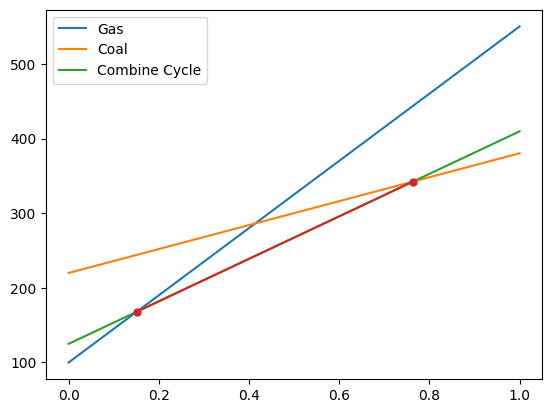

In [18]:
# Create linear space for numerical calculation
step_size = 1e-5
CF = np.arange(0,1.0+step_size,step_size).round(5).tolist()

# print(*stations,sep="\n\n")
minARR = {}
indexMin = {}
intersectionx ,intersectiony, intersectionpoint = [],[],[]
pointPrev = -1

for cf in CF:
    results = []
    for station in stations:
        results.append(station.calculateARR(capacityFactor= cf))

    minARR[cf] = min(results)

    point = indexMin [cf]= min(range(len(results)),key=results.__getitem__)
    if point != pointPrev:
        if cf != 0.0:
            intersectionx.append(cf)
            intersectiony.append(min(results))
            intersectionpoint.append(pointPrev)
        
    pointPrev = point

else:
    intersectionpoint.append(min(range(len(results)),key=results.__getitem__))

print("Screening Curve")
for idx, x in enumerate(intersectionx):
    print(f"Cheapest to run when CF < {round(x,5)} : {stations[idx].stName}  : {round(x*8760,2)} hr" )
else:
    print(f"Cheapest to run when CF > {round(intersectionx[-1],5)} : {stations[-1].stName} : {round(x*8760,2)} hr" )


for station in stations:
    # stationsItem.append(zip(*sorted(station._memo.items())))
    plt.plot(*zip(*sorted(station._memo.items())),label = station.stName)

plt.plot(intersectionx,intersectiony,marker = "o", markersize=5)
plt.legend()
plt.show()

